In [7]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines
import matplotlib.colors as clr
from scipy.stats import kde

In [30]:
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [9]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

In [10]:
#points array for grid interpolation
###creates 2770 vs 2 array of pairs of [u_g_cal,g_r_cal]
points = np.reshape((np.ravel([u_g_cal,g_r_cal],order='F')),(len(u_g_cal),2))

#x,y grid array for grid interpolation
###creates grid from [u_g_cal.min(),u_g_cal.max()]x[g_r_cal.min(),g_r_cal.max()] with 1000 increments
x_grid,y_grid = np.mgrid[(u_g_cal.min()):(u_g_cal.max()):1000j,(g_r_cal.min()):(g_r_cal.max()):1000j]

In [11]:
#use grid interpolation. points are data point coordinates
###feh_cal is the array of data values
###(x_grid,y_grid) are points at which to interpolate data
###method is method of interpolation:
#####nearest: return the value at the data point closest to the point of interpolation.
#####linear: tessellate the input point set to n-dimensional simplices, and interpolate linearly on each simplex
#####cubic: return the value determined from a cubic spline.
#create dictionary with keys nearest, linear, cubic that correspond to arrays of interpolated data
z_grid = {}
for i, method in enumerate(('nearest','linear','cubic')):
    key = method
    z_grid[key] = griddata(points,feh_cal,(x_grid,y_grid),method=method)
  
    

In [12]:
#use binned statistic 2d for original calibration sample
#creat dictionary with keys for original(z3), nearest(z0), linear(z1), and cubic(z2)
ret = {}
xedge = {}
yedge = {}
bin = {}

#original calibration
ret['original'],xedge['original'],yedge['original'],bin['original'] = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)

#nearest interpolation
ret['nearest'],xedge['nearest'],yedge['nearest'],bin['nearest'] = stats.binned_statistic_2d(x_grid[:,0],y_grid[0,:],z_grid['nearest'][:,0],'median',50)

#linear interpolation
ret['linear'],xedge['linear'],yedge['linear'],bin['linear'] = stats.binned_statistic_2d(x_grid[np.isfinite(z_grid['linear'])],y_grid[np.isfinite(z_grid['linear'])],z_grid['linear'][np.isfinite(z_grid['linear'])],'median',50)

#cubic inerpolation
ret['cubic'],xedge['cubic'],yedge['cubic'],bin['cubic'] = stats.binned_statistic_2d(x_grid[np.isfinite(z_grid['cubic'])],y_grid[np.isfinite(z_grid['cubic'])],z_grid['cubic'][np.isfinite(z_grid['cubic'])],'median',50)







/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [13]:
#dictionaries to be used in metallicity function
mean_metallicity = {}
std = {}
for i, method in enumerate(('original','nearest','linear','cubic','nearest_regressor','ivezic')):
    mean_metallicity[method] = []
    std[method] = []

In [14]:
def ivezic_equation(x,y):
    return ((-4.37) + (-8.56)*x + (15.5)*y + (-39.0)*x*y + (23.5)*x**2 + (20.5)*y**2 + (12.1)*(x**2)*y + (7.33)*x*(y**2) + (-10.1)*(x**3) + (-21.4)*y**3)


In [18]:
#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    #newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    #field_number_transient = [int(i) for i in newstr.split()]
    #print("number of initial stars in field "+str(field_number_transient[0])+": "+str(len(objs_new)))
    print("number of initial stars "+str(len(objs_new)))
    
    #append to lists
    #field_number.append(field_number_transient[0])
    #initial_star_count.append(len(objs_new))
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    #selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.4)&(g<=22.8)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    selected = np.where(((g-i)>=-1)&((g-i)<=4)&(g>=14)&(g<=26)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8)&(np.isnan(objs_new['U'])!=True)&(np.isnan(objs_new['G'])!=True)&(np.isnan(objs_new['R'])!=True)&(np.isnan(objs_new['I'])!=True))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    
    #append to list
    #cut_star_count.append(len(cut_u))
    #print("number of initial stars in field "+str(field_number_transient[0])+": "+str(len(objs_new)))
    print("number of stars after color/mag cuts "+str(len(u)))
    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('original','nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        mean_metallicity[method].append(np.nanmean(feh))
        print("mean metallicity for "+method+" method:",(np.nanmean(feh)))
        std[method].append(np.nanstd(feh))
    
    #use machine learning algorithm Nearest Neighbors
    ###The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.
    sample = np.reshape(np.ravel([u_g,g_r],order='F'),(len(u_g),2))   
    knn = neighbors.KNeighborsRegressor(5,weights='uniform')
    feh = knn.fit(points,feh_cal).predict(sample)
    mean_metallicity['nearest_regressor'].append(np.nanmean(feh))
    print("mean metallicity for nearest neighbor regression method:",(np.nanmean(feh)))
    std['nearest_regressor'].append(np.nanstd(feh))
    
    #use equation (4) from Ivezic et al. 2008 to estimate metallicity
    ### x=(u-g) for (g-r)<=0.4; x=(u-g)-2(g-r)+0.8 for (g-r)>0.4
    ### y=(g-r)
    feh = []
    x = u_g -(2*g_r) + 0.8
    index = np.arange(0,len(u_g))
    
    #for i in index:
    #    feh.append([ivezic_equation(u_g[i],g_r[i]) if g_r[i] <= 0.4 else ivezic_equation(x[i],g_r[i])])
    feh.append(ivezic_equation(u_g[i],g_r[i]))
        
    mean_metallicity['ivezic'].append(np.nanmean(feh))
    std['ivezic'].append(np.nanstd(feh))
    print('mean metallicity for ivezic equation method: ',(np.nanmean(feh)))
    
    return 0

## compute metallicity values of 47tuc

In [19]:
if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/47tuc_stars.fits') 

   

number of initial stars 79938
number of stars after color/mag cuts 36224
mean metallicity for original method: -0.8787558386908254
mean metallicity for nearest method: -1.2605326644942965
mean metallicity for linear method: -0.8977361636140101
mean metallicity for cubic method: -0.886401531704576
mean metallicity for nearest neighbor regression method: -0.729933
mean metallicity for ivezic equation method:  -16.0704890773815


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less_equal


## compute metallicity values of NGC 362

In [20]:
if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC362_stars.fits') 

              

number of initial stars 31344
number of stars after color/mag cuts 16439
mean metallicity for original method: -1.163472290489283
mean metallicity for nearest method: -1.5189587839188115
mean metallicity for linear method: -1.1611288547909435
mean metallicity for cubic method: -1.1607910512599864
mean metallicity for nearest neighbor regression method: -0.7495117
mean metallicity for ivezic equation method:  -0.434557023351851


In [31]:
#SMASH standard star fields
standards = '/Users/amyel/research/SMASH_project/datafiles/smash_standards.fits'
fx = fitsio.FITS(standards)
objs = fx[1].read()
u_std = (objs["U"]-(4.239*objs["EBV"]))
g_std = (objs["G"]-(3.303*objs["EBV"]))
i_std = (objs["I"]-(1.263*objs["EBV"]))
r_std = (objs["R"]-(2.285*objs["EBV"]))
u_g_std = u_std - g_std
g_r_std = g_std - r_std
selected = np.where((u_std<=22)&(r_std<=22)&(g_std<=22))
u_std,g_std,r_std = u_std[selected],g_std[selected],r_std[selected]


In [32]:
xx_std, yy_std = np.mgrid[u_g_std.min():u_g_std.max():1000j, g_r_std.min():g_r_std.max():1000j]
positions = np.vstack([xx_std.ravel(), yy_std.ravel()])
values = np.vstack([u_g_std, g_r_std])
k_std = kde.gaussian_kde(values)

In [33]:
zz_std = np.reshape(k_std(positions).T, xx_std.shape)

In [54]:
def density_plots(filename):
    
    fx = fitsio.FITS(filename)
    objs = fx[1].read()
    
    #newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    #field_number = [int(i) for i in newstr.split()]
    
    u = (objs["U"]-(4.239*objs["EBV"]))
    g = (objs["G"]-(3.303*objs["EBV"]))
    i = (objs["I"]-(1.263*objs["EBV"]))
    r = (objs["R"]-(2.285*objs["EBV"]))
    selected = np.where((u<=22)&(r<=22)&(g<=22)&(objs['CHI']<3)&(abs(objs['SHARP'])<1)&(objs['PROB']>.8))
    u,g,r = u[selected],g[selected],r[selected]
    u_g = u-g
    g_r = g-r
    
    fig, ax = plt.subplots(figsize=(20, 10))
    hess = stats.binned_statistic_2d(u_g, g_r, None, 'count',bins=1000)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='bone',norm=clr.LogNorm())
    ax.contour(xx_std,yy_std,zz_std,cmap='spring')
    cb = fig.colorbar(im,ax=ax,label='count in bin')
    ax.set_xlim(-.5,2.7)
    ax.set_ylim(-.5,1.6)
    ax.set_title('Hess Diagram of NGC 362 with Contours of SMASH Standards Overlaid')
    
    plt.show(block=False)
    #print('done with field '+str(field_number))
    return 0


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


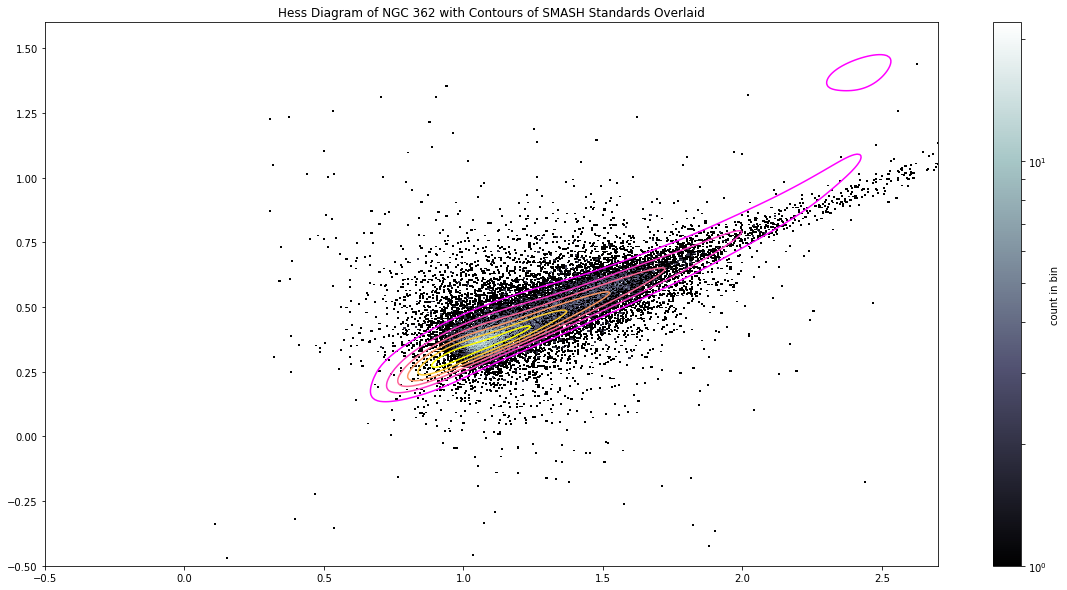

In [55]:
if __name__=="__main__":
    density_plots('/Users/amyel/research/SMASH_project/datafiles/47tuc_stars.fits') 

              

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


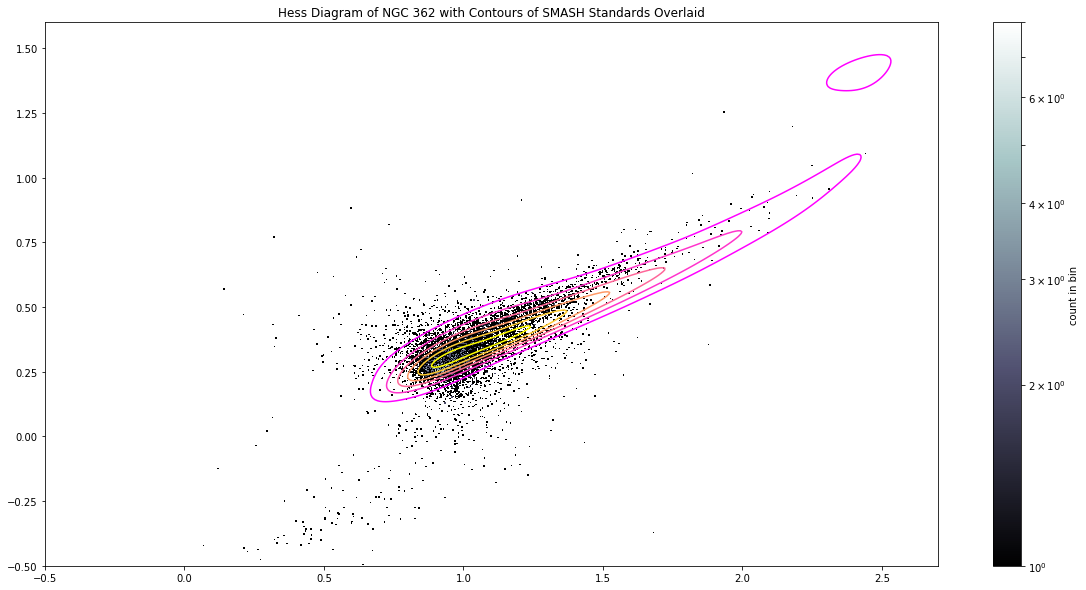

In [56]:
if __name__=="__main__":
    density_plots('/Users/amyel/research/SMASH_project/datafiles/NGC362_stars.fits') 

              